In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'x_train shape: {x_train.shape}\ny_train shape: {y_train.shape}\nx_train shape: {x_test.shape}\ny_train: {y_train.shape}')

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_train shape: (10000, 28, 28)
y_train: (60000,)


## Analyze the data

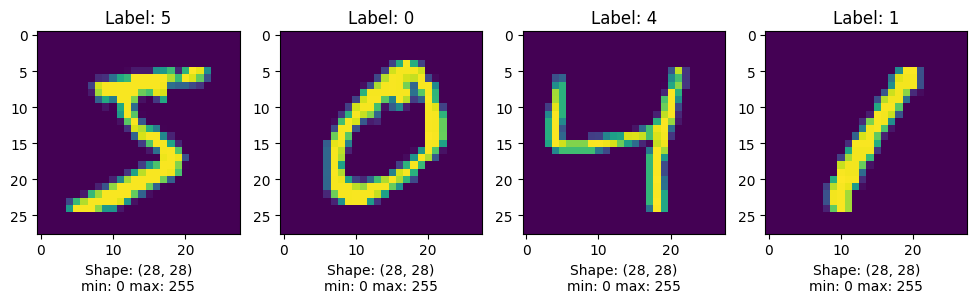

In [3]:
# Plot a sample of the images
fig, ax = plt.subplots(1, 4, figsize=(12, 8))
for i in range(4):
    image: np.ndarray = x_train[i] # Normalize
    label: np.uint8 = y_train[i] # Will be need a one-hot encoding
    ax[i].imshow(image)
    ax[i].set_title(f'Label: {label}')
    ax[i].set_xlabel(f'Shape: {image.shape}\nmin: {image.min()} max: {image.max()}')

In [4]:
# Add a new dimension of total labels
from tensorflow.keras.utils import to_categorical

print(f'y_train: {y_train.shape} y_test: {y_test.shape}')
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test, num_classes=10)
print(f'y_cat_train: {y_cat_train.shape} y_cat_test: {y_cat_test.shape} ')

y_train: (60000,) y_test: (10000,)
y_cat_train: (60000, 10) y_cat_test: (10000, 10) 


In [5]:
# Normalization of the data (0-255) -> (0-1)
print(f'x_train min: {x_train.min()} max: {x_train.max()}, x_test min: {x_test.min()} max: {x_test.max()}')
x_train = x_train / 255
x_test = x_test / 255
print(f'x_train min: {x_train.min()} max: {x_train.max()}, x_test min: {x_test.min()} max: {x_test.max()}')

x_train min: 0 max: 255, x_test min: 0 max: 255
x_train min: 0.0 max: 1.0, x_test min: 0.0 max: 1.0


In [6]:
# Reshape

# Add a channel dimension
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}')
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}')

x_train shape: (60000, 28, 28), x_test shape: (10000, 28, 28)
x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


## Create the model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [8]:
# Create the model
model = Sequential()

model.add(Conv2D(
    filters=32, # Increase by n^2 if we have lots of labels/classes
    kernel_size=(4, 4),
    input_shape=x_train.shape[1:],
    padding='valid',
    activation='relu',
))

# Half the size of ^ kernel_size form the previous layer
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


2023-07-05 14:24:23.818463: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-05 14:24:23.818480: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-05 14:24:23.818486: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-05 14:24:23.818516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-05 14:24:23.818532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [10]:
# Train the model
model.fit(x_train, y_cat_train, 
          epochs=10,
          validation_data=[x_test, y_cat_test],
          callbacks=[early_stop])

Epoch 1/10
   8/1875 [..............................] - ETA: 14s - loss: 1.9531 - accuracy: 0.3750 

2023-07-05 14:24:24.190420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1869/1875 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9572

2023-07-05 14:24:37.376817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 15s 8ms/step - loss: 0.1433 - accuracy: 0.9572 - val_loss: 0.0675 - val_accuracy: 0.9772
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0690 - accuracy: 0.9791 - val_loss: 0.0626 - val_accuracy: 0.9814
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0693 - accuracy: 0.9810 - val_loss: 0.0902 - val_accuracy: 0.9776


## Evaluate the model

In [11]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.143339,0.957250,0.067523,0.9772
1,0.069008,0.979133,0.062564,0.9814
2,0.069332,0.980983,0.090166,0.9776


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
predictions = model.predict(x_test)
predictions.shape

104/313 [========>.....................] - ETA: 0s

2023-07-05 14:25:08.894707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 1ms/step


(10000, 10)

In [14]:
# Calculate the confusion matrix on the test set
print(classification_report(y_test, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.99      0.97       974
           9       0.99      0.94      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



<Axes: >

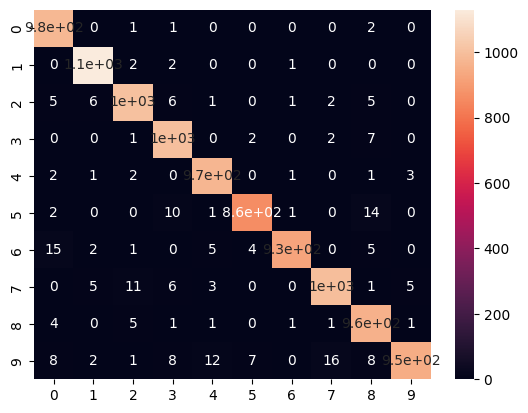

In [15]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, np.argmax(predictions, axis=1)), annot=True)

Text(0.5, 0, 'epochs')

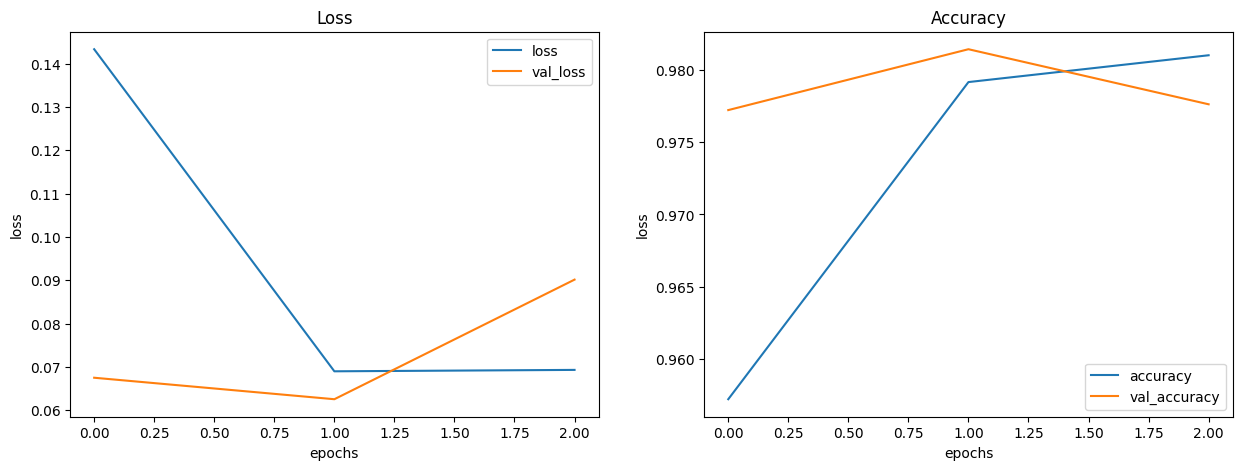

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(metrics[['loss', 'val_loss']])
ax[0].set_title('Loss')
ax[0].legend(['loss', 'val_loss'])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epochs')

ax[1].plot(metrics[['accuracy', 'val_accuracy']])
ax[1].set_title('Accuracy')
ax[1].legend(['accuracy', 'val_accuracy'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epochs')

1/1 [==============================] - 0s 24ms/step


'Prediction: 7'

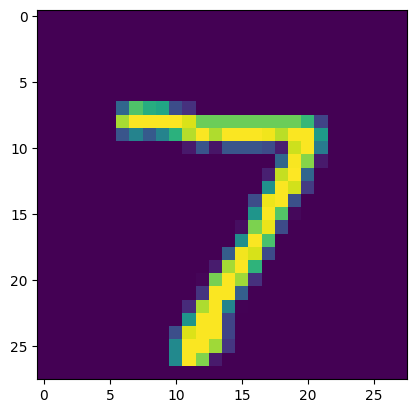

In [17]:
# Predict the number 7
my_number = x_test[0]
predict = model.predict(my_number.reshape(1, *my_number.shape))

plt.imshow(my_number.reshape(28, 28))
f'Prediction: {np.argmax(predict)}'